# HW#8 Autoencoder

안녕하세요, 광운대학교 로봇학부의 오정현 교수입니다. 본 자료는 딥러닝 실습 수업을 위해 제작된 것입니다.

파이썬 문법
- 점프투파이썬(https://wikidocs.net/book/1) 참고

이번 과제는 Unsupervised Learning의 대표적인 구조인 Autoencoder에 대하여 다루도록 하겠습니다. 

이번 과제는 keras에서 제공하는 좋은 예제가 있으니 참고하시기 바랍니다.
(https://keraskorea.github.io/posts/2018-10-23-keras_autoencoder/)

#1. Basic Autoencoder

오토 인코더는 인풋 데이터를 latent representation으로 압축하는 encoder와 다시 데이터를 복원하는 decoder가 합쳐진 구조로 되어 있습니다. 링크를 참고하여 bottleneck latent dimension이 작을 때와 클 때 reconstruction되는 이미지가 어떻게 달라지는지 결과를 비교해 보세요.




keras의 fashion_mnist를 사용하였습니다.

이미지 해상도는 28X28이고, 총 10개의 label로 구분됩니다.

AutoEncoder는 비지도 학습이기 때문에 y는 지정하지 않겠습니다.

In [0]:
import keras
import numpy as np

"""
keras의 fashion_mnist를 사용하였습니다.

이미지 해상도는 28X28이고, 총 10개의 label로 구분됩니다.

AutoEncoder는 비지도 학습이기 때문에 y는 지정하지 않겠습니다.
"""

fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape) 
print(x_test.shape) 

(60000, 784)
(10000, 784)


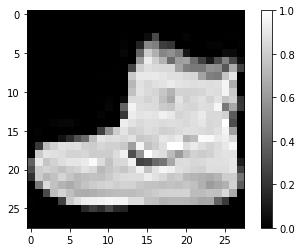

In [16]:
#image plot해보기
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_train[0].reshape(28,28)) #plt를 위해 reshape
plt.colorbar()
plt.grid(False)
plt.show()

In [0]:
epoch = 100
batch_size = 526

In [0]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping

#이번 과제에도 빠질 수 없는 callback함수입니다
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=10,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

filename = 'checkpoint-basic-epoch-{}-batch-{}-trial-001.h5'.format(epoch, batch_size)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=10,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

우선 기본 Dense로 AE를 구성해보았습니다.

예제의 MNIST에선 아래와 같이 기본 Dense로만 이루어진 AE가 좋은 성능을 내었습니다.
아래는 3층의 Dense로 encoder와 decoder를 구성하여 만든 AE결과입니다.
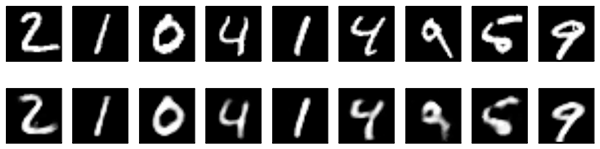

복원이 잘되었음을 알 수 있습니다.

 
조금 더 복잡한 FashionMNIST에서의 결과를 확인해 보겠습니다.

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.callbacks import TensorBoard


"""# 입력 플레이스홀더
input_img = Input(shape=(784,))
# "encoded"는 입력의 인코딩된 표현
input_img = Input(shape=(784,))
encoded = Dense(526, activation='relu')(input_img)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoder = Model(input_img, encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(526, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)"""

encoding_dim = 32
# 입력 플레이스홀더
input_img = Input(shape=(784,))
# "encoded"는 입력의 인코딩된 표현
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded"는 입력의 손실있는 재구성 (lossy reconstruction)
decoded = Dense(784, activation='sigmoid')(encoded)

# 입력을 입력의 재구성으로 매핑할 모델
autoencoder = Model(input_img, decoded)


# 입력을 입력의 재구성으로 매핑할 모델
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
# 인코딩된 입력을 위한 플레이스 홀더
encoded_input = Input(shape=(encoding_dim,))
# 오토인코더 모델의 마지막 레이어 얻기
decoder_layer = autoencoder.layers[-1]
# 디코더 모델 생성
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [20]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [21]:
autoencoder.fit(x_train, x_train,
                epochs=epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[reduceLR,checkpoint, earlystopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.5667 - val_loss: 0.5020

Epoch 00001: val_loss improved from inf to 0.50196, saving model to checkpoint-basic-epoch-100-batch-526-trial-001.h5
Epoch 2/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.4771 - val_loss: 0.4516

Epoch 00002: val_loss improved from 0.50196 to 0.45160, saving model to checkpoint-basic-epoch-100-batch-526-trial-001.h5
Epoch 3/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.4320 - val_loss: 0.4179

Epoch 00003: val_loss improved from 0.45160 to 0.41789, saving model to checkpoint-basic-epoch-100-batch-526-trial-001.h5
Epoch 4/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.4089 - val_loss: 0.4035

Epoch 00004: val_loss improved from 0.41789 to 0.40347, saving model to checkpoint-basic-epoch-100-batch-526-trial-001.h5
Epoch 5/100
60000/60000 [=============

In [0]:
"""# 이 모델은 입력을 입력의 인코딩된 입력의 표현으로 매핑
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# 오토인코더 모델의 마지막 레이어 얻기
decoder_layer = autoencoder.layers[-1]
# 디코더 모델 생성
decoder = Model(encoded_input, decoder_layer(encoded_input))"""
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

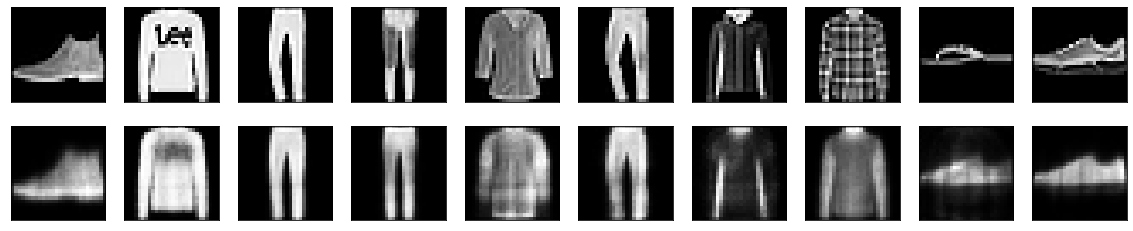

In [23]:
# Matplotlib 사용
import matplotlib.pyplot as plt

n = 10  # 몇 개의 숫자를 나타낼 것인지
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

예제이 있는 MNIST보다 복잡한 fashion MNIST에 대해, Dense로만 구성한 AutoEncoder는 좋은 성능을 내지 못했습니다.

#2. Convolutional Autoencoder

Convolutional Autoencoder를 만들어 보세요. Autoencoder와 다른 점이 무엇인지 살펴보고 bottleneck latent dimension이 작을 때와 클 때 reconstruction되는 이미지가 어떻게 달라지는지 결과를 비교해 보세요.



In [0]:
"""
Conv2D를 사용할 것이기 때문에 data를 reshape해줍니다.
"""
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [25]:
print(x_train.shape) 
print(x_test.shape) 

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [26]:

from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Reshape, UpSampling2D

inputs = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
x = Flatten()(x)
encoded = Dense(2, activation='relu')(x)

encoder = Model(inputs=inputs, outputs=encoded)
print(inputs.shape)
encoded_inputs = Input(shape=(2,))

x = Dense(4, activation='relu')(encoded_inputs)
x = Reshape((2, 2, 1))(x)
x = Conv2D(4, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((7, 7))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded.shape)
decoder = Model(inputs=encoded_inputs, outputs=decoded)

x = encoder(inputs)
x = decoder(x)

autoencoder_cnn = Model(inputs, x)
autoencoder_cnn.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder_cnn.summary()

(None, 28, 28, 1)
(None, 28, 28, 1)
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_9 (Model)              (None, 2)                 78529     
_________________________________________________________________
model_10 (Model)             (None, 28, 28, 1)         77161     
Total params: 155,690
Trainable params: 155,386
Non-trainable params: 304
_________________________________________________________________


In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용

In [28]:
filename = 'checkpoint-AECNN_1-epoch-{}-batch-{}-trial-001.h5'.format(epoch, batch_size)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

autoencoder_cnn.fit(x_train, x_train,
                epochs=epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[reduceLR,checkpoint, earlystopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 34s 566us/step - loss: 0.4511 - val_loss: 0.6249

Epoch 00001: val_loss improved from inf to 0.62490, saving model to checkpoint-AECNN_1-epoch-100-batch-526-trial-001.h5
Epoch 2/100
60000/60000 [==============================] - 26s 439us/step - loss: 0.3996 - val_loss: 0.6403

Epoch 00002: val_loss did not improve from 0.62490
Epoch 3/100
60000/60000 [==============================] - 27s 445us/step - loss: 0.3879 - val_loss: 0.5636

Epoch 00003: val_loss improved from 0.62490 to 0.56362, saving model to checkpoint-AECNN_1-epoch-100-batch-526-trial-001.h5
Epoch 4/100
60000/60000 [==============================] - 27s 446us/step - loss: 0.3823 - val_loss: 0.5401

Epoch 00004: val_loss improved from 0.56362 to 0.54013, saving model to checkpoint-AECNN_1-epoch-100-batch-526-trial-001.h5
Epoch 5/100
60000/60000 [==============================] - 27s 444us/step - loss: 0.3713 - val_

In [0]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

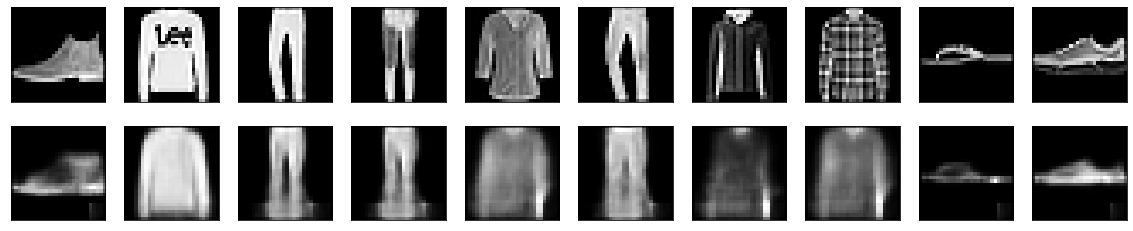

In [30]:

n = 10  # 몇 개의 숫자를 나타낼 것인지
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

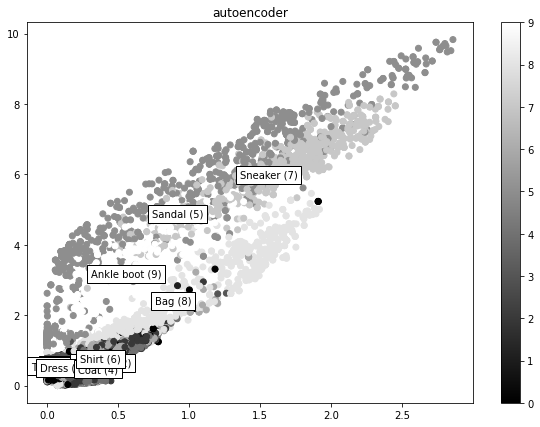

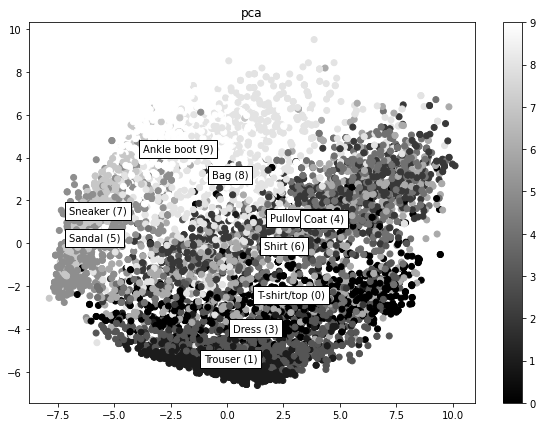

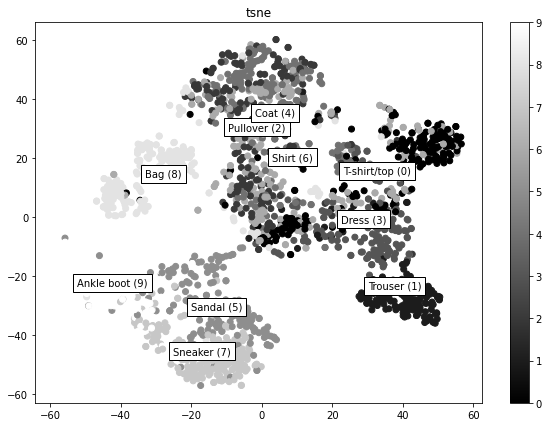

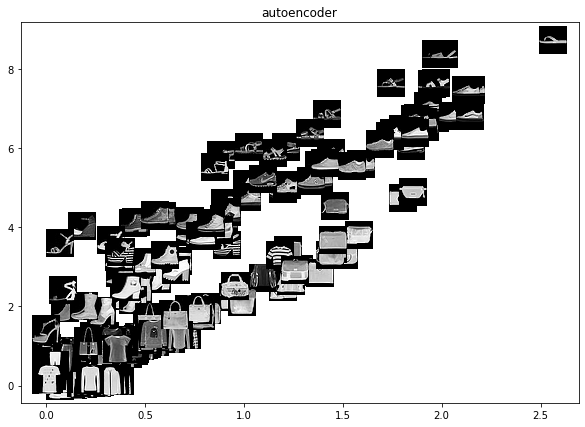

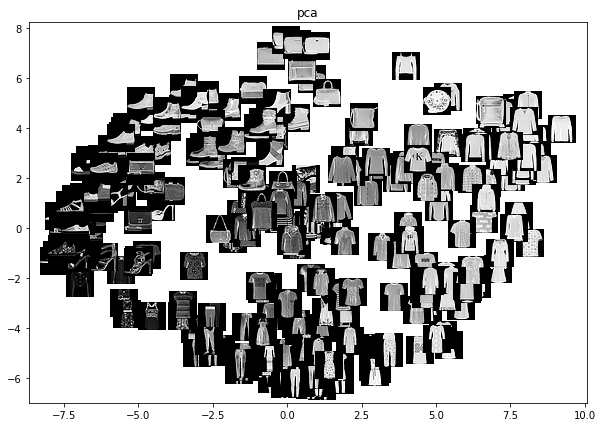

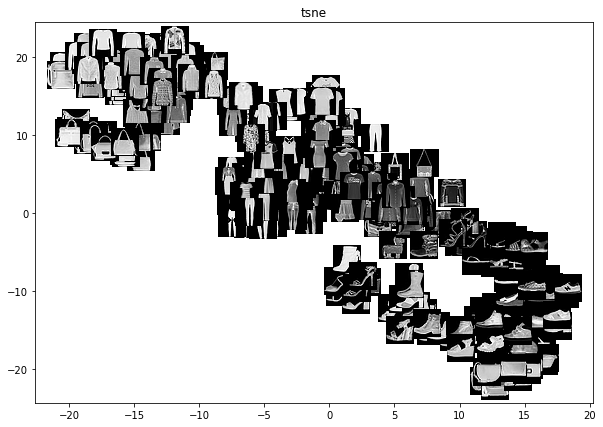

In [36]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea

labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

def plot_latent(mode, count, technique):
    idx = np.random.choice(len(x_test), count)
    inputs = x_test[idx]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'autoencoder':
        coords = encoder.predict(inputs)
    elif technique == 'pca':
        coords = PCA(n_components=2).fit_transform(inputs.reshape(count, -1))
    elif technique == 'tsne':
        coords = TSNE(n_components=2).fit_transform(inputs.reshape(count, -1))

    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    elif mode == 'dots':
        classes = y_test[idx]
        plt.scatter(coords[:, 0], coords[:, 1], c=classes)
        plt.colorbar()
        for i in range(10):
            class_center = np.mean(coords[classes == i], axis=0)
            text = TextArea('{} ({})'.format(labeldict[i], i))
            ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
            ax.add_artist(ab)
    plt.show()

plot_latent('dots', 10000, 'autoencoder')
plot_latent('dots', 10000, 'pca')
plot_latent('dots', 2000, 'tsne')

plot_latent('imgs', 300, 'autoencoder')
plot_latent('imgs', 300, 'pca')
plot_latent('imgs', 300, 'tsne')

#3. Denoising Autoencoder

Fashion MIST data + noise



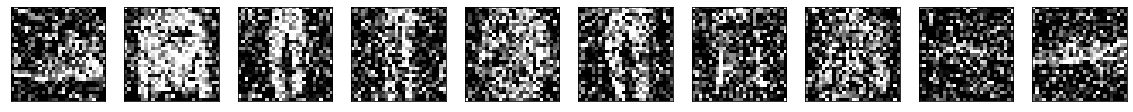

In [37]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
n = 10
plt.figure(figsize=(20, 2))

for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [38]:

filename = 'checkpoint-AECNN-noise-epoch-{}-batch-{}-trial-001.h5'.format(epoch, batch_size)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

autoencoder_cnn.fit(x_train_noisy, x_train,
                epochs=epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[reduceLR,checkpoint, earlystopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 26s 439us/step - loss: 0.3429 - val_loss: 0.4334

Epoch 00001: val_loss improved from inf to 0.43339, saving model to checkpoint-AECNN-noise-epoch-100-batch-526-trial-001.h5
Epoch 2/100
60000/60000 [==============================] - 27s 444us/step - loss: 0.3398 - val_loss: 0.3664

Epoch 00002: val_loss improved from 0.43339 to 0.36635, saving model to checkpoint-AECNN-noise-epoch-100-batch-526-trial-001.h5
Epoch 3/100
60000/60000 [==============================] - 27s 446us/step - loss: 0.3389 - val_loss: 0.3510

Epoch 00003: val_loss improved from 0.36635 to 0.35098, saving model to checkpoint-AECNN-noise-epoch-100-batch-526-trial-001.h5
Epoch 4/100
60000/60000 [==============================] - 27s 445us/step - loss: 0.3407 - val_loss: 0.3595

Epoch 00004: val_loss did not improve from 0.35098
Epoch 5/100
60000/60000 [==============================] - 27s 446us/step - loss: 0

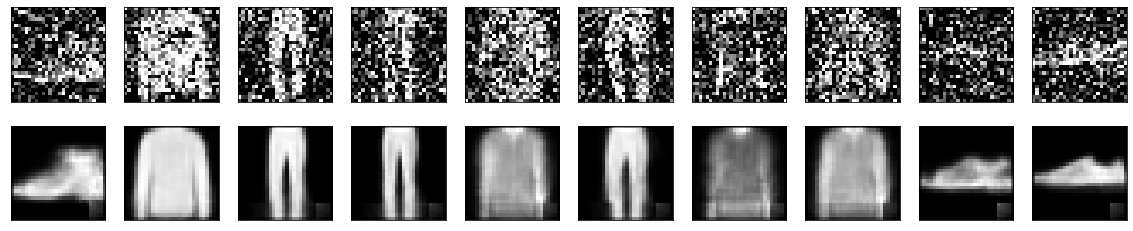

In [39]:
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10  # 몇 개의 숫자를 나타낼 것인지
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 데이터
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성된 데이터
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()